# Use cases

In this notebook, we describe different use cases for
 applying stochastic service composition.


In [1]:
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from examples.notebooks.utils import render_service, render_target, render_composition_mdp, print_policy_data
from stochastic_service_composition.composition import composition_mdp
from stochastic_service_composition.services import build_service_from_transitions
from stochastic_service_composition.target import build_target_from_transitions


## Simple service composition: Website

This simple example, showed in

[De Giacomo, G., Mecella, M., & Patrizi, F. (2014).
Automated service composition based on behaviors: The roman model.
In Web services foundations (pp. 189-214). Springer, New York, NY.](http://www.diag.uniroma1.it/degiacom/papers/2014/WSF14.pdf)

consists of a simple website in which the user wants
to login, choose the country, stock, and logout (c).
We then have the login service (a) and the form
service (b). The orchestrator (d) has to assign
the action to the right service. This case is
quite trivial as there is no competition
among services since they always support different actions.
The reward, in our case, is given whenever the user is able
to complete the entire sequence of actions, right after the logout

![_](images/simple-service-composition.png)

Let us define the service community:

In [2]:
login_service = build_service_from_transitions(
    {
        "s0": {"login": "s1"},
        "s1": {"logout": "s0"}
    },
    "s0",
    {"s0"}
)

form_service = build_service_from_transitions(
    {
        "s0": {"country": "s1"},
        "s1": {"currency": "s0", "stock": "s0"}
    },
    "s0",
    {"s0"}
)

The login service:

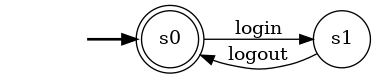

In [3]:
render_service(login_service)

The form service:

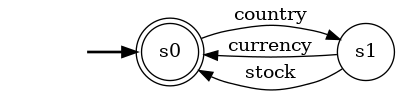

In [4]:
render_service(form_service)

Now we define the target service:

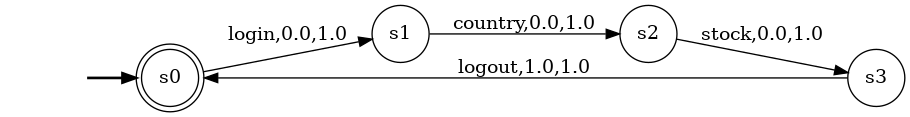

In [5]:
target = build_target_from_transitions(
    {
        "s0": {"login": ("s1", 1.0, 0.0)},
        "s1": {"country": ("s2", 1.0, 0.0)},
        "s2": {"stock": ("s3", 1.0, 0.0)},
        "s3": {"logout": ("s0", 1.0, 1.0)},
    },
    "s0",
    {"s0"}
)
render_target(target)

The product MDP is:

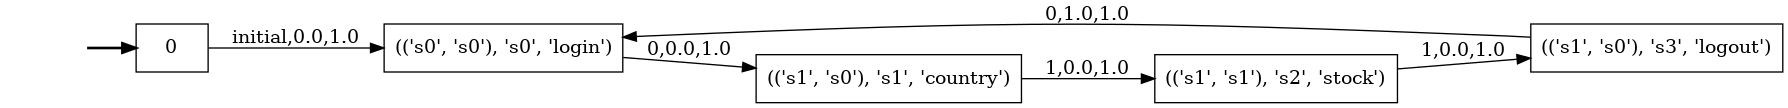

In [6]:
mdp = composition_mdp(target, login_service, form_service)
render_composition_mdp(mdp)

The optimal policy is the only one allowed

In [7]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy_pi = opn.get_optimal_policy_pi()
print_policy_data(opt_policy_pi)

State=0, Action=initial
State=(('s0', 's0'), 's0', 'login'), Action=0
State=(('s1', 's0'), 's1', 'country'), Action=1
State=(('s1', 's1'), 's2', 'stock'), Action=1
State=(('s1', 's0'), 's3', 'logout'), Action=0


That is, as expected, `login` and `logout` are assigned
 to service `0` and `country` and `stock` to service `1`.

## A variant of the website service

Here we consider a variant in which the services can
erroneously report that they can provide a service,
but that leads to a dead-end.
An exact solution is still possible,
and the solution of the composition MDP
will lead to the right orchestration.

Let's define the same services, but with additional
actions:

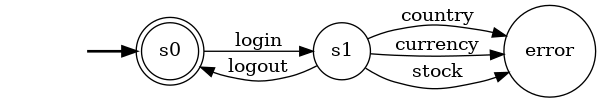

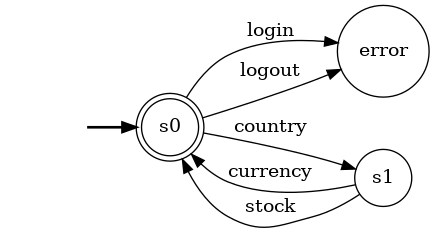

In [8]:
login_service = build_service_from_transitions(
    {
        "s0": {
            "login": "s1"
        },
        "s1": {
            "logout": "s0",
            "country": "error",
            "currency": "error",
            "stock": "error"
        },
        "error": {}
    },
    "s0",
    {"s0"}
)

form_service = build_service_from_transitions(
    {
        "s0": {"login": "error", "logout": "error", "country": "s1"},
        "s1": {"currency": "s0", "stock": "s0"},
        "error": {}
    },
    "s0",
    {"s0"}
)

render_service(login_service)
render_service(form_service)

This time, the composition MDP is:

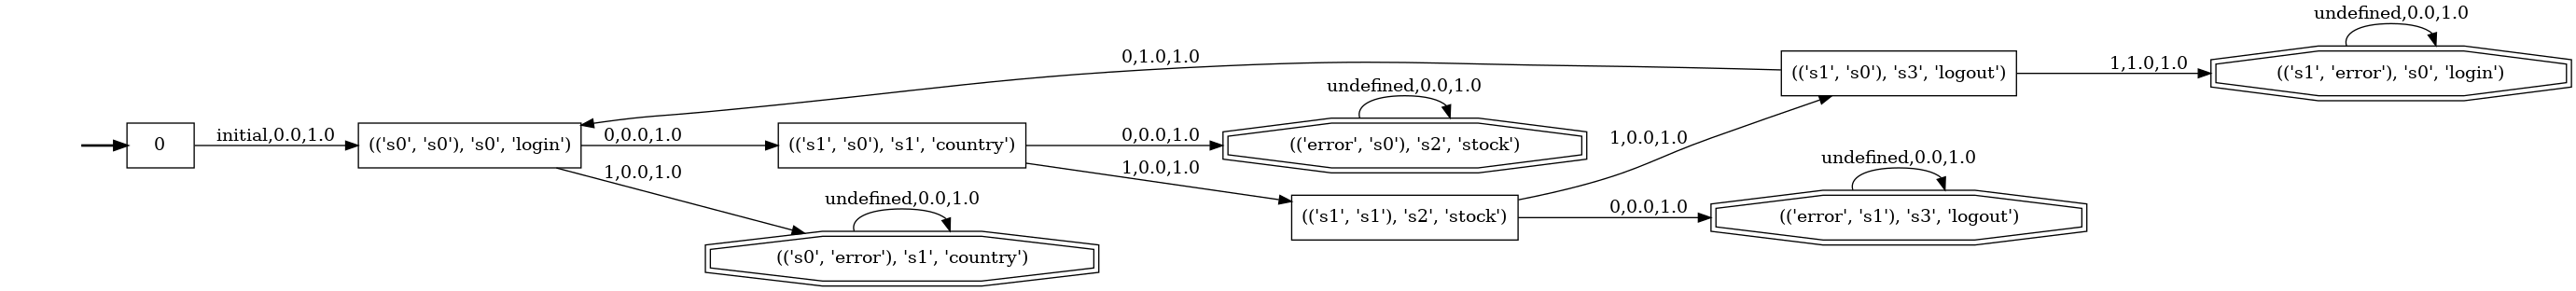

In [9]:
mdp = composition_mdp(target, login_service, form_service)
render_composition_mdp(mdp)

The optimal policy correctly avoids dead ends:

In [10]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy_pi = opn.get_optimal_policy_pi()
print_policy_data(opt_policy_pi)

State=0, Action=initial
State=(('s0', 's0'), 's0', 'login'), Action=0
State=(('s1', 's0'), 's1', 'country'), Action=1
State=(('s0', 'error'), 's1', 'country'), Action=undefined
State=(('error', 's0'), 's2', 'stock'), Action=undefined
State=(('s1', 's1'), 's2', 'stock'), Action=1
State=(('error', 's1'), 's3', 'logout'), Action=undefined
State=(('s1', 's0'), 's3', 'logout'), Action=0
State=(('s1', 'error'), 's0', 'login'), Action=undefined


## Human-Robot Collaboration (HRC) use case

 We use the case study described in:

[Tsarouchi, P., Makris, S., & Chryssolouris, G. (2016).
On a human and dual-arm robot task planning method.
Procedia CIRP, 57, 551-555.](https://www.sciencedirect.com/science/article/pii/S2212827116312495)

Another useful reference:
[Wang, L., Liu, S., Liu, H., & Wang, X. V. (2020).
Overview of Human-Robot Collaboration in Manufacturing.
In Proceedings of 5th International Conference on
the Industry 4.0 Model for Advanced Manufacturing
(pp. 15-58). Springer, Cham.](https://link.springer.com/chapter/10.1007/978-3-030-46212-3_2)


Consider the following scenario:
 we have a robot and a human positioned
 in the same workstation.
 TODO
